# Token Approximation — EDA and Baselines

Concise analysis and baseline models to approximate input token counts from local text features.

Technical depth (ablations, diagnostics, learning curves) is in `02_appendix_diagnostics.ipynb`.

## Overview and Hypothesis

- Hypothesis: Local text features (bytes, runes, words, lines) can approximate provider language model input token counts.
- Why it matters: Enables local budgeting without remote tokenizers, helpful for throughput, cost, and context management.
- Approach: Benchmark a simple single-feature baseline versus multifeature linear models with regularization; report held-out test performance plus train-CV stability.
- Scope: Token counts are tokenizer- and language model-specific; external validity may vary.
- Terminology: “runes” = Unicode code points; features used: bytes, runes, words, lines.

## Data

- Data source: `data/processed/datasets/dataset.jsonl` produced by the Go features runner over sample texts.
- Columns: `bytes`, `runes` (Unicode code points), `words`, `lines`, `input_tokens`, `model`, `source_path`.

### Imports

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from IPython.display import display, Markdown
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from utils import (
    SEED as SEED_DEFAULT, N_GRID_DEFAULT, MAPE_THRESHOLD_DEFAULT, DECISION_MARGIN_DEFAULT, CV_SPLITS_A_DEFAULT, CV_SPLITS_DEFAULT, CV_REPEATS_DEFAULT, BOOT_B_DEFAULT, FEATURES,
    load_records, validate_records, corr_heatmap, cv_single_feature, select_best, fit_single_feature, approach_b_ridge_cv, approach_b_elasticnet_cv, summarize_and_decide, repeated_cv_mae, bootstrap_mae_ci, export_single_feature, export_linear_multifeature, coef_sanity_checks, best_subset_ols, abs_error_stats, plot_abs_error_hist, mape_filtered, scatter_grid_regplot, resolve_chosen_predictions,
)

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

### Configuration

In [2]:
# Defaults can be overridden as needed
SEED = SEED_DEFAULT  # random seed for splits/CV
N_GRID = N_GRID_DEFAULT  # learning-curve grid
MAPE_THRESHOLD = MAPE_THRESHOLD_DEFAULT  # floor for computing MAPE
DECISION_MARGIN = DECISION_MARGIN_DEFAULT  # min relative MAE gain to pick B over A
CV_SPLITS_A = CV_SPLITS_A_DEFAULT  # folds for A-selection CV
CV_SPLITS = CV_SPLITS_DEFAULT  # folds for stability CV + learning curves
CV_REPEATS = CV_REPEATS_DEFAULT  # repeats for stability CV
BOOT_B = BOOT_B_DEFAULT  # bootstrap resamples
MODEL_NAME = "claude-3-7-sonnet-latest"  # tokenizer/model scope

display(Markdown(
    f"""Constants set for this run:
- `SEED`=`{SEED}`
- `DECISION_MARGIN`=`{DECISION_MARGIN}`
- `MAPE_THRESHOLD`=`{MAPE_THRESHOLD}`
- `CV_SPLITS` x `CV_REPEATS`=`{CV_SPLITS}` x `{CV_REPEATS}`
"""
))

Constants set for this run:
- `SEED`=`42`
- `DECISION_MARGIN`=`0.03`
- `MAPE_THRESHOLD`=`50`
- `CV_SPLITS` x `CV_REPEATS`=`10` x `5`


### Load and Validate Data

In [3]:
base = Path('..').resolve()
dataset_path = base / 'data' / 'processed' / 'datasets' / 'dataset.jsonl'
print({'dataset_path': str(dataset_path)})

df = load_records(dataset_path)
df = validate_records(df)
print(df.attrs.get('validation_info', {}))
df.head()

{'dataset_path': '/Users/peta/Documents/dev/token-approx/data/processed/datasets/dataset.jsonl'}
{'total_before': 25, 'drops': {'input_tokens_na': 0, 'bytes_non_numeric_or_na': 0, 'runes_non_numeric_or_na': 0, 'words_non_numeric_or_na': 0, 'lines_non_numeric_or_na': 0}, 'total_after': 25}


,bytes,runes,words,lines,input_tokens,model,source_path
0,36027,35491,6086,702,9566,claude-3-7-sonnet-latest,data/processed/samples/oliver-twist_gberg_samp...
1,36733,35737,6209,747,9702,claude-3-7-sonnet-latest,data/processed/samples/oliver-twist_gberg_samp...
2,36961,35965,6199,735,9798,claude-3-7-sonnet-latest,data/processed/samples/oliver-twist_gberg_samp...
3,36649,35953,6438,719,9552,claude-3-7-sonnet-latest,data/processed/samples/oliver-twist_gberg_samp...
4,36572,35584,6297,776,9536,claude-3-7-sonnet-latest,data/processed/samples/oliver-twist_gberg_samp...


## Exploratory Visuals

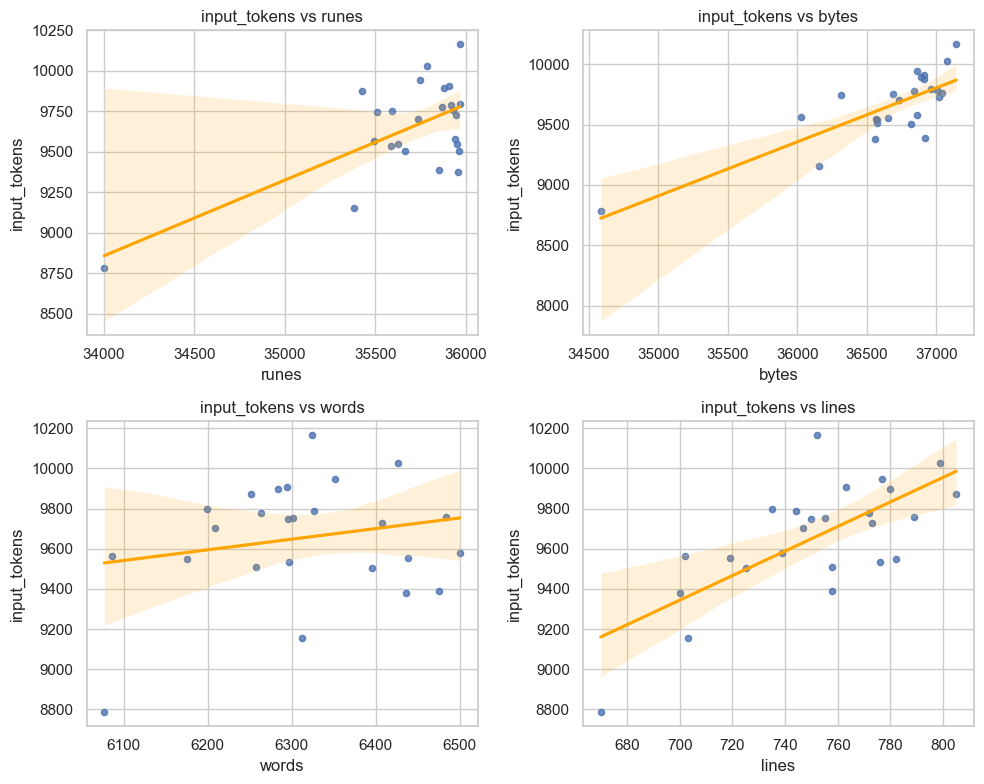

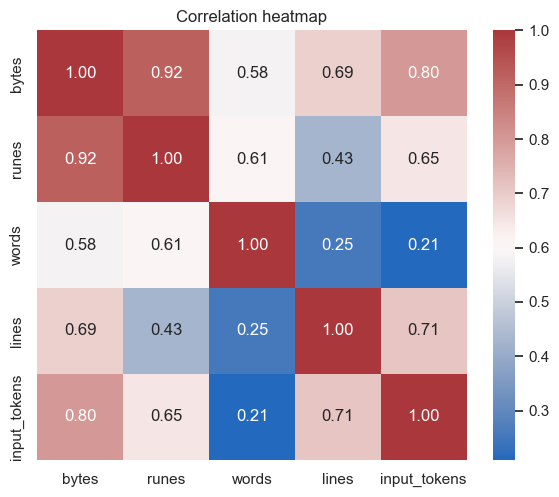

In [4]:
sns.set_theme(style='whitegrid')

pairs = [
    ('runes', 'input_tokens'),
    ('bytes', 'input_tokens'),
    ('words', 'input_tokens'),
    ('lines', 'input_tokens'),
]
_ = scatter_grid_regplot(
    df,
    pairs=pairs,
    figsize=(10, 8),
    scatter_kws={'s': 20, 'alpha': 0.8},
    line_kws={'color': 'orange'},
)

ax = corr_heatmap(df)

### Takeaways

- Strong linear trends between input tokens and bytes/runes.
- Features are correlated; multicollinearity likely → regularization/subset selection is appropriate.

## Approach A — Single-Feature Linear Regression: CV Selection

Train: CV to select feature/intercept. Evaluate on a held‑out test split.

MAE is the headline metric. MAPE is reported only when `y`>=`MAPE_THRESHOLD` to avoid instability on small targets.

Single-feature baseline calibrates expectations before multi-feature models

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

# CV across single features and intercept options
features_list = FEATURES
rows = []
for feat in features_list:
    Xtr_feat = train_df[[feat]].to_numpy()
    ytr = train_df['input_tokens'].to_numpy()
    for fi in (False, True):
        mae_cv, bias_cv = cv_single_feature(Xtr_feat, ytr, fit_intercept=fi, n_splits=CV_SPLITS_A, seed=SEED)
        rows.append({'feature': feat, 'fit_intercept': fi, 'cv_mae': mae_cv, 'cv_bias': bias_cv})
cv_results = pd.DataFrame(rows).sort_values(['cv_mae', 'feature', 'fit_intercept']).reset_index(drop=True)

best_cv = select_best(cv_results)
res_a = fit_single_feature(train_df, test_df, feature=best_cv['feature'], fit_intercept=bool(best_cv['fit_intercept']))

display(Markdown('#### CV results (train) (Approach A)'))
display(cv_results)

y_true_sf = res_a['yte']
y_pred_sf = res_a['pred']
mape = mape_filtered(y_true_sf, y_pred_sf, threshold=MAPE_THRESHOLD)

display(Markdown('#### Held-out Test Results (Approach A)'))
display(pd.DataFrame([{
    'stage': 'A_single_feature_test',
    'feature': res_a['feature'],
    'fit_intercept': res_a['fit_intercept'],
    'test_mae': res_a['test_mae'],
    'test_bias': res_a['test_bias'],
    'MAPE_after_filter': mape,
    'MAPE_after_filter_pct': None if mape is None else 100*mape,
}]))

#### CV results (train) (Approach A)

,feature,fit_intercept,cv_mae,cv_bias
0,bytes,True,144.427594,7.752838
1,bytes,False,169.869769,-1.329659
2,runes,False,201.408403,-0.881323
3,lines,True,207.923194,-19.519454
4,runes,True,245.207236,-56.612640
5,lines,False,273.942573,7.287553
6,words,False,274.350196,1.557482
7,words,True,283.337983,-18.730074


#### Held-out Test Results (Approach A)

,stage,feature,fit_intercept,test_mae,test_bias,MAPE_after_filter,MAPE_after_filter_pct
0,A_single_feature_test,bytes,True,154.600783,75.950348,0.01585,1.584973


## Approach B — Multi-Feature Linear Regression: OLS-best-subset; Ridge/ElasticNet via CV

Train: OLS subset search; Ridge/ElasticNet via CV. Evaluate on a held‑out test split.

In [6]:
# 1) Regularized baselines (Ridge, ElasticNet)
res_b_ridge = approach_b_ridge_cv(train_df, test_df, seed=SEED)
res_b_enet  = approach_b_elasticnet_cv(train_df, test_df, seed=SEED)

# 2) OLS best-subset
res_b_ols = best_subset_ols(train_df, test_df, features=FEATURES)

# Show results
def _features_from_result(res):
    if 'coefs' in res and isinstance(res['coefs'], dict) and res['coefs']:
        return ','.join(sorted(res['coefs'].keys()))
    cols = res.get('cols', [])
    return ','.join(cols) if cols else 'bytes,runes,words,lines'

def _row(res, family, selection_basis):
    row = {
        'family': family,
        'model': res.get('model', family),
        'selection': selection_basis,
        'features': _features_from_result(res),
        'test_mae': float(res['test_mae']),
        'test_bias': float(res['test_bias']),
    }
    if 'alpha' in res: row['alpha'] = res['alpha']
    if 'l1_ratio' in res: row['l1_ratio'] = res['l1_ratio']
    return row

# Build finalists (one per family)
b_rows = []
if res_b_ols is not None:
    b_rows.append(_row(res_b_ols, family='OLS', selection_basis='best subset by test MAE'))
if res_b_ridge is not None:
    b_rows.append(_row(res_b_ridge, family='Ridge', selection_basis='alpha via CV on train'))
if res_b_enet is not None:
    b_rows.append(_row(res_b_enet, family='ElasticNet', selection_basis='alpha,l1_ratio via CV on train'))

b_df = pd.DataFrame(b_rows).sort_values('test_mae').reset_index(drop=True)

# Add improvement vs A and highlight best
a_mae = float(res_a['test_mae'])
b_df_enh = b_df.copy()
b_df_enh['improve_vs_A_pct'] = 100.0 * (a_mae - b_df_enh['test_mae']) / a_mae

def _hl_best(s):
    is_best = (s.index == b_df_enh['test_mae'].idxmin())
    return ['font-weight: bold; background-color: #1e3a8a22' if v else '' for v in is_best]

display(Markdown("### Held‑out Test Results (Approach B finalists)"))
display(Markdown("_Each row is the best candidate for its family (OLS best subset; Ridge and ElasticNet with CV-selected hyperparameters)._"))
display(
    b_df_enh[['family','model','selection','features','test_mae','test_bias','improve_vs_A_pct','alpha','l1_ratio']]
    .style.format({'test_mae':'{:.2f}','test_bias':'{:.2f}','improve_vs_A_pct':'{:+.1f}%'})
    .apply(_hl_best, axis=0)
)

### Held‑out Test Results (Approach B finalists)

_Each row is the best candidate for its family (OLS best subset; Ridge and ElasticNet with CV-selected hyperparameters)._

,family,model,selection,features,test_mae,test_bias,improve_vs_A_pct,alpha,l1_ratio
0,OLS,OLS_best_subset,best subset by test MAE,"bytes,words",128.64,45.73,+16.8%,nan,nan
1,ElasticNet,ElasticNetCV,"alpha,l1_ratio via CV on train","bytes,lines,runes,words",134.75,36.06,+12.8%,0.484369,0.500000
2,Ridge,Ridge,alpha via CV on train,"bytes,lines,runes,words",141.15,28.13,+8.7%,1.000000,nan


## Model Selection and Decision

We select B only if it reduces MAE over A by more than the `DECISION_MARGIN`, to avoid overreacting to small differences.

In [7]:
summary_b = summarize_and_decide(
    res_a,
    res_b_ols=res_b_ols,
    res_b_ridge=res_b_ridge,
    res_b_enet=res_b_enet,
    prefer_margin=DECISION_MARGIN,
)

rows = [
    {
        'approach': 'A_single_feature',
        'feature': res_a['feature'],
        'fit_intercept': res_a['fit_intercept'],
        'test_mae': res_a['test_mae'],
        'test_bias': res_a['test_bias'],
    }
]
bd = summary_b.get('B_details')
if isinstance(bd, dict):
    feat_str = ','.join(sorted(bd.get('coefs', {}).keys()))
    rows.append({
        'approach': f"B_{bd.get('model')}",
        'feature': feat_str if feat_str else 'bytes,runes,words,lines',
        'fit_intercept': True,
        'test_mae': bd.get('test_mae'),
        'test_bias': bd.get('test_bias'),
    })

display(Markdown(f"### Held‑out Test Results - A vs B Decision"))
display(Markdown(f"#### Decision: {summary_b.get('decision')} -—> {summary_b.get('reason')}"))
display(pd.DataFrame(rows))

### Held‑out Test Results - A vs B Decision

#### Decision: B -—> Approach B (OLS_best_subset) beats A by 16.8% MAE (> 3% margin).

,approach,feature,fit_intercept,test_mae,test_bias
0,A_single_feature,bytes,True,154.600783,75.950348
1,B_OLS_best_subset,"bytes,words",True,128.641883,45.734170


### Takeaways

- On this split, B (OLS best-subset bytes+words) outperforms A by ~17% MAE and lowers bias.
- This means tighter token budgeting with similar calibration (split-dependent).

## Stability and Uncertainty

Repeated-CV (stability) with bootstrap CIs (uncertainty) on train to assess for A and the chosen B.

In [8]:
# Train-only repeated-CV
y_all = train_df['input_tokens'].to_numpy()
mean_y = float(train_df['input_tokens'].mean())

# A
feat = best_cv['feature']
fi = bool(best_cv['fit_intercept'])
XA = train_df[[feat]].to_numpy()
maeA, ytA, ypA = repeated_cv_mae(
    XA, y_all,
    model_factory=lambda: LinearRegression(fit_intercept=fi),
    n_splits=CV_SPLITS, n_repeats=CV_REPEATS, seed=SEED,
)
loA, hiA = bootstrap_mae_ci(ytA, ypA, B=BOOT_B, seed=SEED)
biasA = float(np.mean(ytA - ypA))

# B (use chosen best model params if available)
B_row = None
if summary_b['B_best_model'] is not None:
    model_name = summary_b['B_best_model']
    
    # Determine the feature set to use for repeated-CV
    if model_name in ('OLS', 'OLS_best_subset'):
        # Use the exact subset chosen (derived from coef keys)
        feature_set = sorted(summary_b['B_details'].get('coefs', {}).keys())
        XB = train_df[feature_set].to_numpy()
        mf = lambda: LinearRegression(fit_intercept=True)
    elif model_name == 'Ridge':
        feature_set = ['bytes','runes','words','lines']
        alpha = summary_b['B_details'].get('alpha', 1.0)
        XB = train_df[feature_set].to_numpy()
        mf = lambda: Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha, fit_intercept=True)),
        ])
    elif model_name == 'ElasticNetCV':
        feature_set = ['bytes','runes','words','lines']
        alpha = summary_b['B_details'].get('alpha', 1.0)
        l1_ratio = summary_b['B_details'].get('l1_ratio', 0.5)
        XB = train_df[feature_set].to_numpy()
        mf = lambda: Pipeline([
            ('scaler', StandardScaler()),
            ('enet', ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True, max_iter=100000, random_state=SEED)),
        ])
    else:
        mf = None
        feature_set = None

    if mf is not None:
        maeB, ytB, ypB = repeated_cv_mae(
            XB, y_all,
            model_factory=mf,
            n_splits=CV_SPLITS, n_repeats=CV_REPEATS, seed=SEED,
        )
        loB, hiB = bootstrap_mae_ci(ytB, ypB, B=BOOT_B, seed=SEED)
        biasB = float(np.mean(ytB - ypB))
        B_row = {
            'approach': f"B_{model_name}",
            'feature': ','.join(feature_set) if feature_set else 'bytes,runes,words,lines',
            'fit_intercept': True,
            'MAE': float(maeB),
            'CI95_lo': float(loB),
            'CI95_hi': float(hiB),
            'bias': biasB,
        }

rows = [
    {
        'approach': f"A_single_feature({feat}{',+b' if fi else ''})",
        'feature': feat,
        'fit_intercept': fi,
        'MAE': float(maeA),
        'CI95_lo': float(loA),
        'CI95_hi': float(hiA),
        'bias': biasA,
    }
]
if B_row is not None:
    rows.append(B_row)

report_df = pd.DataFrame(rows, columns=['approach','feature','fit_intercept','MAE','CI95_lo','CI95_hi','bias'])
display(Markdown('#### Train-CV stability (MAE with 95% CI)'))
display(report_df)

#### Train-CV stability (MAE with 95% CI)

,approach,feature,fit_intercept,MAE,CI95_lo,CI95_hi,bias
0,"A_single_feature(bytes,+b)",bytes,True,163.065026,138.916261,189.105635,16.031685
1,B_OLS_best_subset,"bytes,words",True,143.376267,124.067713,163.411822,3.711023


## Error Analysis

Absolute error distribution for the chosen model; we report median and 95th percentile.

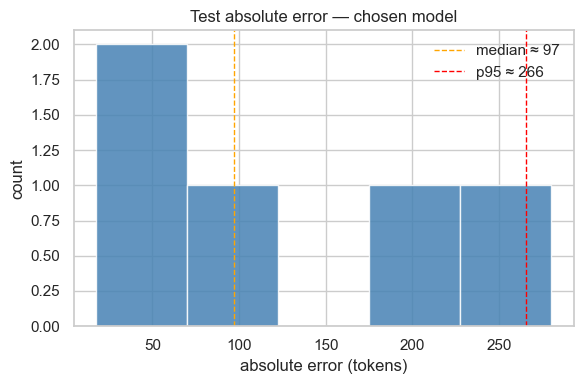

Typical error (chosen model B:OLS_best_subset): median 97.2 tokens; p95 265.7; max 280.3.

In [9]:
y_true, y_pred, chosen_label = resolve_chosen_predictions(
    summary_b=summary_b,
    res_a=res_a,
    res_b_ols=res_b_ols,
    res_b_ridge=res_b_ridge,
    res_b_enet=res_b_enet,
)

stats = abs_error_stats(y_true, y_pred)
med, p95, mx, n = stats['median'], stats['p95'], stats['max'], stats['n']

_ = plot_abs_error_hist(
    y_true, y_pred,
    bins=max(3, min(7, n)),
    title='Test absolute error — chosen model',
    show_refs=True,
    ref_values=(med, p95),
)

display(Markdown(
    f"Typical error (chosen model {chosen_label}): "
    f"median {med:.1f} tokens; p95 {p95:.1f}; max {mx:.1f}."
))

### Takeaways

- n=5 test set → indicative only.
- Typical error ≈ 100 tokens; tail ≈ 250–280 tokens.
- Good enough for budgeting; add a safety buffer when near limits.

## Export winning model coefficients

In [10]:
rows = [
    {
        'approach': 'A_single_feature',
        'feature': res_a['feature'],
        'fit_intercept': res_a['fit_intercept'],
        'test_mae': res_a['test_mae'],
        'test_bias': res_a['test_bias'],
    }
]
if isinstance(summary_b.get('B_details'), dict):
    bd = summary_b['B_details']
    feat_str = ','.join(sorted(bd.get('coefs', {}).keys()))
    rows.append({
        'approach': f"B_{bd.get('model')}",
        'feature': feat_str if feat_str else 'bytes,runes,words,lines',
        'fit_intercept': True,
        'test_mae': bd.get('test_mae'),
        'test_bias': bd.get('test_bias'),
    })

MODEL_NAME = MODEL_NAME
try:
    decision = summary_b.get('decision') if isinstance(summary_b, dict) else None
    if decision == 'A' and isinstance(res_a, dict):
        out_path = export_single_feature(
            feature_type=res_a['feature'],
            a=res_a['coef_a'],
            b=res_a['intercept_b'],
            model=MODEL_NAME,
            scope='en-long-one-turn',
            estimator='LinearRegression',
            fit_intercept=res_a['fit_intercept'],
        )
        print({'exported': str(out_path), 'type': 'single', 'feature': res_a['feature']})
    elif decision == 'B' and isinstance(summary_b.get('B_details'), dict):
        best_b = summary_b['B_details']
        flags = coef_sanity_checks(best_b.get('coefs', {}))
        if flags.get('negative_bytes') or flags.get('negative_runes'):
            print({'warning': 'coef sanity flags', **flags})

        # Feature set: derive from coefs keys
        feature_set = sorted(best_b.get('coefs', {}).keys())

        out_path = export_linear_multifeature(
            intercept=best_b['intercept'],
            coefs=best_b['coefs'],
            model=MODEL_NAME,
            scope='en-long-one-turn',
            estimator=best_b.get('model'),  # e.g., 'OLS_best_subset', 'Ridge', 'ElasticNetCV'
            feature_set=feature_set,
        )
        print({'exported': str(out_path), 'type': 'linear', 'model': best_b.get('model'), 'alpha': best_b.get('alpha', None), 'feature_set': feature_set})
    else:
        print({'export': 'skipped', 'reason': 'missing or invalid decision summary'})
except NameError as e:
    print({'export': 'skipped', 'reason': f'NameError: {e}'})

{'exported': '/Users/peta/Documents/dev/token-approx/models/model_coefs.json', 'type': 'linear', 'model': 'OLS_best_subset', 'alpha': None, 'feature_set': ['bytes', 'words']}


## Further Exploration

For learning curves and extended diagnostics, see the companion appendix notebook: `02_appendix_diagnostics.ipynb`.

## Reproducibility

- Python: 3.13+
- Install: `pip install -r requirements.txt`
- Data path: `data/processed/datasets/dataset.jsonl`
- Seeds and CV folds are controlled via the `Constants` section.

In [11]:
import platform

display(Markdown(f"""### Library versions:\n{'\n'.join([f'- {k}: {v}' for k, v in {'python': platform.python_version(), 'numpy': np.__version__, 'pandas': pd.__version__, 'sklearn': sklearn.__version__}.items()])}"""))

### Library versions:
- python: 3.13.5
- numpy: 2.3.4
- pandas: 2.3.3
- sklearn: 1.7.2